## Setup

In [1]:
# Check versions of Keras and Tensorflow
!pip list | egrep 'keras|tensorflow$'

keras                                    2.13.1
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.3.5


In [2]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
Keras version: 2.13.1, backend: tensorflow
GPUs: 1


## Configure our experiments

You'll be invited to change parameters in this code block later; for now just run it as-is.

In [3]:
class config:
    seed = 123
    learning_rate = 1e-4
    epochs = 50
    batch_size = 9
    image_size = (256, 256)
    model_preset = "efficientnetv2_b2_imagenet"
    use_zero_init = True

In [4]:
# Reproducibility
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
#
# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [5]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://students.cs.calvin.edu/~ajm94/CS-375/HW01/letters.zip",
    extract=True,
)

305468/305468 [==============================] - 0s 1us/step


Let's see what just got downloaded.

In [6]:
data_path = Path(path_to_downloaded_file).parent / 'letters'
!ls {data_path}

A  B  C


We'll use a Keras helper function to load the data.

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [7]:
# Define which classes we want to use, in what order.
class_names = ['A', 'B', 'C']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 100 files belonging to 3 classes.
Using 80 files for training.
Using 20 files for validation.


Let's show some example images.

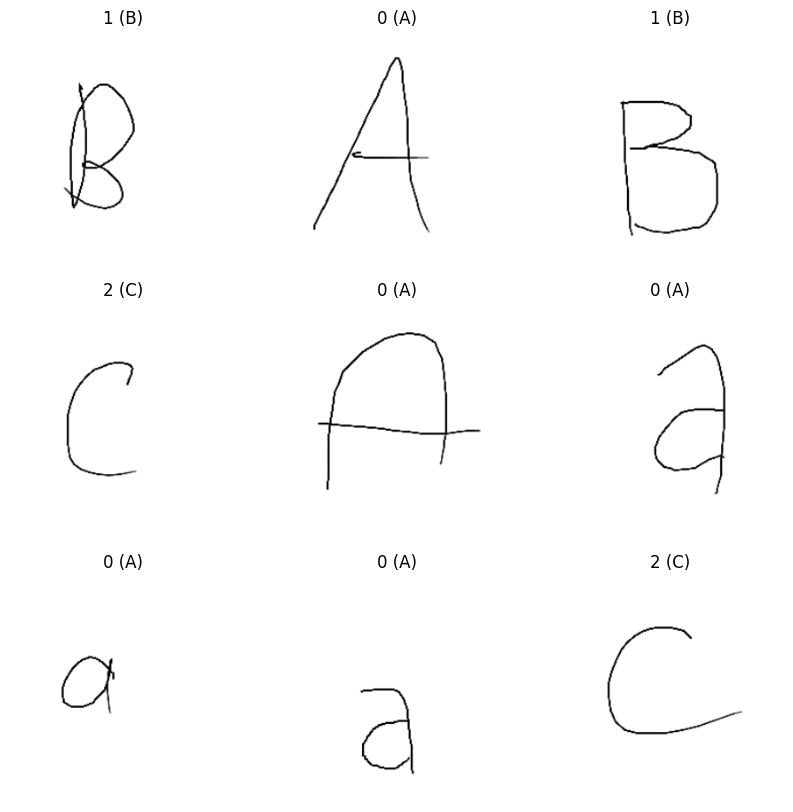

In [8]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')
# Alternative approach (doesn't show labels)
# keras_cv.visualization.plot_image_gallery(example_images, value_range=(0, 255))

### Train a model

We'll unpack this code over the next several weeks. For now, pay attention to the progress bar that will (eventually) show on the last line of the output.

In [9]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Zero the output-layer weights (they were randomly initialized, which adds noise to gradients when fine-tuning)
# I was reminded of this by https://twitter.com/wightmanr/status/1742570388016758822
if config.use_zero_init:
    output_layer = model.layers[-1]
    output_layer.set_weights([w * 0 for w in output_layer.weights])

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "image_classifier"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, None, None, 3)]   0         Y          
                                                                            
 efficient_net_v2b2_backbon  (None, None, None, 1408   8769374   Y          
 e (EfficientNetV2Backbone)  )                                              
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1408)              0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 3)                 4227      Y          
                                                                            
Total params: 8773601 (33.47 MB)
Trainable params:

2024-01-31 18:01:07.322605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inimage_classifier/efficient_net_v2b2_backbone/block1b_/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 61s 397ms/step - loss: 1.0956 - accuracy: 0.4250 - val_loss: 1.0907 - val_accuracy: 0.5000
Epoch 2/50
9/9 [==============================] - 1s 95ms/step - loss: 1.0773 - accuracy: 0.6500 - val_loss: 1.0695 - val_accuracy: 0.5500
Epoch 3/50
9/9 [==============================] - 1s 94ms/step - loss: 1.0483 - accuracy: 0.6750 - val_loss: 1.0286 - val_accuracy: 0.5500
Epoch 4/50
9/9 [==============================] - 1s 93ms/step - loss: 1.0088 - accuracy: 0.7000 - val_loss: 0.9755 - val_accuracy: 0.6500
Epoch 5/50
9/9 [==============================] - 1s 93ms/step - loss: 0.9190 - accuracy: 0.8625 - val_loss: 0.8975 - val_accuracy: 0.8500
Epoch 6/50
9/9 [==============================] - 1s 92ms/step - loss: 0.8027 - accuracy: 0.9250 - val_loss: 0.8130 - val_accuracy: 0.8500
Epoch 7/50
9/9 [==============================] - 1s 92ms/step - loss: 0.6571 - accuracy: 0.9750 - val_loss: 0.6547 - val_accuracy: 0.9000
Epoch 8/50
9/9 [====================

### Make some predictions

   8192/Unknown - 0s 0us/step

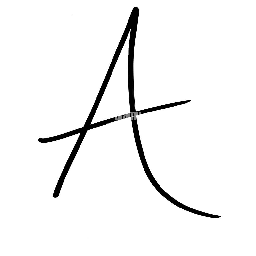

In [10]:
# Load a new image
image_file = keras.utils.get_file(origin='https://c8.alamy.com/comp/2APBC2W/the-letter-a-handwritten-on-a-white-background-2APBC2W.jpg')
image = keras.utils.load_img(image_file, target_size=(256, 256), keep_aspect_ratio=True)
display(image)

In [11]:
probabilities = model.predict(np.array(image)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

1/1 [==============================] - 2s 2s/step


,class,prob
0,A,0.971070
1,B,0.017989
2,C,0.010941


### Confusion Matrix

3/3 [==============================] - 2s 18ms/step


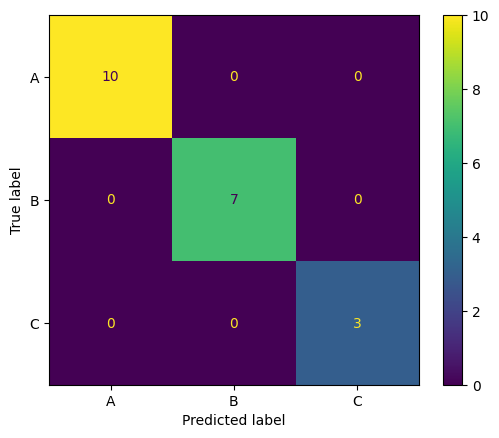

In [12]:
val_predicted_probs = model.predict(val_dataset)
val_predictions = np.argmax(val_predicted_probs, axis=1)
val_labels = [int(label) for img, label in val_dataset.unbatch()]

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(val_labels, val_predictions, display_labels=class_names)

# Analysis

This is a handwritten dataset of the letters 'A', 'B', and 'C', upper and lowercase. I gathered this data using a mouse on [this website](https://codepen.io/kcarnold/full/poZpdqX). There are 45 letter 'A's, 38 letter 'B's, 17 letter 'C's.

20% of the data is in the validation set. While the rest is in the training set.

The classifier is fairly accurate, always getting into the high 90s, for the validation set. It is the worst at classifing the letter 'c'. This is probably caused by the letter c being significantly the least represented in my dataset. 

It did not make any mistakes.

I think that these things are caused by the lack of the letter 'c's representation in the training dataset and the overrepresentation of the letter 'a' in the dataset.

I think that the likelihood is pretty high because I had asked multiple different people to write down letters to try and get a more diverse dataset. I would have to guess that other people's datasets would have an accuracy of roughly 85% accuracy on my model with the letter 'c' being the weakest link in the chain.

I had to choose how many of each letter that I wanted to use in the training set and how many epochs that I wanted to run. Chaning the number of images in each category can change the accuracy on each data and the epoch change can increase or decrease the accuracy and the training time. 